In [110]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely import wkt
import matplotlib.pyplot as plt
from pyproj import Proj, transform

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_18457/1502285015.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  G.geometry.centroid.plot(alpha=0.2, markersize=10)


<AxesSubplot: >

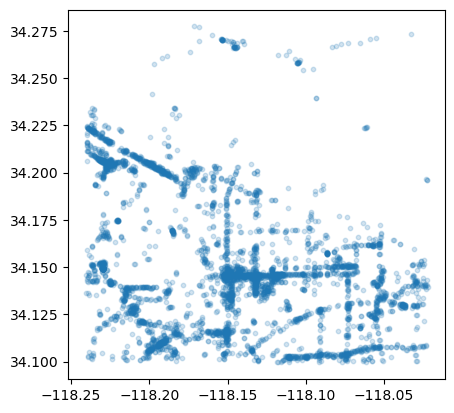

In [167]:
center_point = (34.1902, -118.1313)
tags = {'amenity':True, 'landuse':['retail','commercial'], 'highway':'bus_stop'}
G = ox.geometries_from_point(center_point, tags, dist=10000)
G.geometry.centroid.plot(alpha=0.2, markersize=10)

In [153]:
ca_data_pd = pd.read_csv('ca_data.csv')
ca_data_pd['geometry'] = ca_data_pd['geometry'].apply(wkt.loads)
ca_data = gpd.GeoDataFrame(ca_data_pd)
#ca_data['pov_pct'] = ca_data['total_pov_below'] / ca_data['total_pop']
#ca_data['area'] = ca_data.geometry.area
#ca_data['pop_density'] = ca_data['total_pop'] / ca_data['area']
#ca_data.to_csv('ca_data.csv')
poor_urban_tracts = ca_data[(ca_data['pov_pct'] > 0.18) & \
    #(ca_data['pov_pct'] < 0.5) & \
    (ca_data['pop_density'] > 0.000153)]

In [163]:
poor_urban_tracts.geometry.area.describe()

count    1.824000e+03
mean     3.316752e+06
std      4.912937e+06
min      9.073566e+04
25%      8.633952e+05
50%      1.760596e+06
75%      3.468537e+06
max      4.783457e+07
dtype: float64

In [156]:
inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')

centroids = poor_urban_tracts.geometry.centroid
poor_urban_tracts['centroids'] = centroids.apply(lambda c: transform(inProj, outProj, \
    c.coords[0][0], c.coords[0][1], always_xy=True))
poor_urban_tracts['centroids'] = centroids_tuples.apply(lambda t: (t[1], t[0]))

/Users/giuseppeperona/opt/anaconda3/envs/ox/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/giuseppeperona/opt/anaconda3/envs/ox/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_18457/2389091517.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.i

In [169]:
center_point = t
tags = {'amenity':True, 'landuse':['retail','commercial'], 'highway':'bus_stop'}

def get_n_pois(row):
    center_point = row['centroid']
    area = row['area']
    dist = np.sqrt(area) / 2
    G = ox.geometries_from_point(center_point, tags, dist=1732)
    print(row.index)
    return len(G)

poor_urban_tracts.sample(10).apply(lambda r: get_n_pois(r))

KeyError: 'centroid'

In [149]:
pois = np.array([])
for i, t in enumerate(centroids_tuples[:100]):
    center_point = t
    tags = {'amenity':True, 'landuse':['retail','commercial'], 'highway':'bus_stop'}
    G = ox.geometries_from_point(center_point, tags, dist=1732)
    #G.geometry.centroid.plot(alpha=0.2, markersize=10)
    pois = np.append(pois, len(G))
    print(i, t, len(G))

0 (41.76059032481567, -124.16400824044464) 24
1 (41.84589910773804, -124.16385071904692) 6
2 (41.76714640351725, -123.85438672800176) 0
3 (41.74512761456493, -124.2052479732011) 93
4 (41.775514354740835, -124.19306049455027) 31
5 (41.793941348258315, -124.2552760408243) 1
6 (41.75176524203953, -124.24972201769188) 2
7 (41.58548761300498, -124.03070217742287) 0
8 (41.347656100837995, -122.32781649893388) 3
9 (41.701252480473514, -122.91166896727624) 0
10 (41.7722051675141, -122.32166343491778) 0
11 (41.22615010234093, -122.32718491446383) 1
12 (41.859862780521766, -121.94038265068964) 0
13 (41.74567825085907, -123.33482836740255) 0
14 (41.74328494718255, -122.64218402425712) 63
15 (41.67449874056907, -122.66342308283956) 0
16 (41.482601876734506, -122.43547425523673) 11
17 (41.350678754181615, -123.03846764868868) 0
18 (41.413577824182774, -121.81388853422297) 0
19 (41.72779718465311, -122.6159454485368) 25
20 (41.7898772304863, -121.62230154083134) 0
21 (41.936643327172305, -122.637726

In [145]:
pois

array([ 24.,   6.,   0.,  93.,  31.,   1.,   2.,   0.,   3.,   0.,   0.,
         1.,   0.,   0.,  63.,   0.,  11.,   0.,   0.,  25.,   0.,   0.,
         0.,   0.,  40.,   0., 151., 108.,   0.,   0.,   8.,   3.,   2.,
         0.,   0.,   0.,  62., 119.,   0.,   0.,  45.,  14.,   1.,   0.,
         0., 534., 507., 107.,   4.,   0.])